# Notebook 1: Estimating Rates

[Bayesian Inference with PyMC](https://allendowney.github.io/BayesianInferencePyMC)

Copyright 2021 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install PyMC and ArviZ
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist
    !pip install pymc3
    !pip install arviz

In [2]:
import matplotlib.pyplot as plt

import numpy as np
import pymc3 as pm

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Poisson process

I'll model hockey as a Poisson process, where each team has some long-term average scoring rate, $\mu$, in goals per game.

To get started, let's assume that $\mu$ is somehow known to be 2.4 goals per game.

We can use NumPy to generate a sample from a Poisson distribution.

In [3]:
mu = 2.4
sample_poisson = np.random.poisson(mu, 1000)
np.mean(sample_poisson)

2.356

To show the distribution of the quantities, I'll use the following function, which returns a Pandas `Series`.

In [4]:
import pandas as pd

def make_pmf(sample):
    """Make a Series that represents a PMF.
    
    sample: sequence of values
    
    returns: Pandas Series
    """
    return pd.Series(sample).value_counts(normalize=True, sort=False).sort_index()

The index of the `Series` contains the possible quantities; the values in the `Series` are their probabilities.

In [5]:
pmf_poisson = make_pmf(sample_poisson)
pmf_poisson

0    0.107
1    0.200
2    0.281
3    0.194
4    0.125
5    0.056
6    0.030
7    0.004
8    0.003
dtype: float64

The following function takes a sample and plots the PMF as a bar chart.

In [6]:
def plot_pmf(sample, **options):
    """Plot the PMF of a sample as a bar chart."""
    pmf = make_pmf(sample)
    plt.bar(pmf.index, pmf.values, **options)

And this one decorates the axes.

In [7]:
def decorate_goals(ylabel='PMF'):
    """Decorate the axes."""
    plt.xlabel('Number of goals')
    plt.ylabel(ylabel)
    plt.title('Distribution of goals scored')
    plt.legend()

Here's what the distribution looks like.

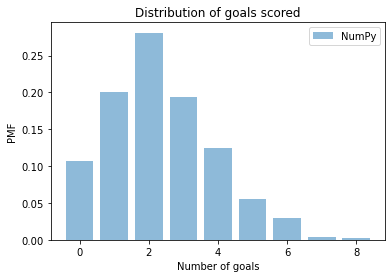

In [8]:
plot_pmf(sample_poisson, label='NumPy', alpha=0.5)
decorate_goals()

## Warming up PyMC

Soon we will want to use `pymc3` to do inference, which is really what it's for.  But just to get warmed up, I will use it to generate a sample from a Poisson distribution.

In [9]:
model = pm.Model()

with model:
    goals = pm.Poisson('goals', mu)
    trace = pm.sample_prior_predictive(1000)

This example runs the model forward and puts the results into `trace`, which is a mapping type.

In [10]:
len(trace['goals'])

1000

In [11]:
sample_pymc = trace['goals']
np.mean(sample_pymc)

2.418

The results from PyMC are similar to what we got from NumPy.

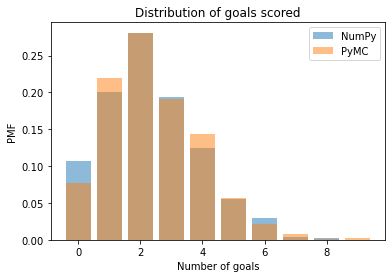

In [12]:
plot_pmf(sample_poisson, label='NumPy', alpha=0.5)
plot_pmf(sample_pymc, label='PyMC', alpha=0.5)
decorate_goals('PMF')

This example is like using a cannon to kill a fly.  But it help us learn to use the cannon.

## Evaluating the Poisson distribution

One of the nice things about the Poisson distribution is that we can compute its PMF analytically, and SciPy provides an implementation.

In [13]:
from scipy.stats import poisson

mu = 2.4
xs = np.arange(11)
ps = poisson.pmf(xs, mu)

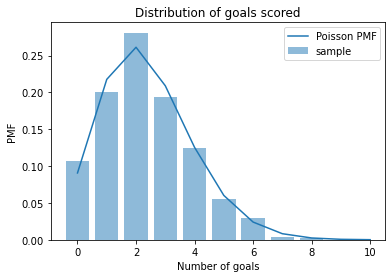

In [14]:
plot_pmf(sample_poisson, label='sample', alpha=0.5)
plt.plot(xs, ps, label='Poisson PMF')

decorate_goals()

## The Likelihood Function

Here's the probability of scoring 4 goals in a game if the long-term rate is 2.4 goals per game.

In [15]:
data = 4
poisson.pmf(data, mu)

0.1254084986272838

And here's the likelihood of 4 goals for a range of possible values of `mu`.

In [16]:
mus = np.linspace(0, 15, num=101)
likelihood = poisson.pmf(4, mus)

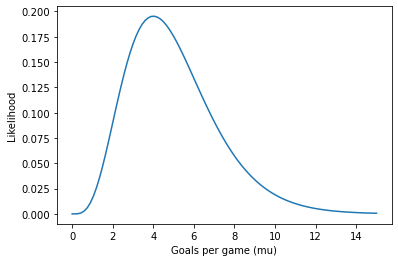

In [17]:
plt.plot(mus, likelihood)
plt.xlabel('Goals per game (mu)')
plt.ylabel('Likelihood');

## Bayesian inference with grid approximation

Ok, it's finally time to do some inference!  The function we just wrote computes the likelihood of the data, given a hypothetical value of `mu`:

$\mathrm{Prob}~(x ~|~ \mu)$

But what we really want is the distribution of `mu`, given the data:

$\mathrm{Prob}~(\mu ~|~ x)$

If only there were some theorem that relates these probabilities!

We can use `make_gamma_pmf` to construct a prior suite with the given parameters.

In [18]:
from scipy.stats import gamma

def make_gamma_pmf(qs, alpha, beta):
    """Makes a PMF based on a gamma distribution.
    
    qs: places to evaluate the PDF
    alpha, beta: parameters of the distribution
    
    returns: pd.Series
    """
    ps = gamma(a=alpha, scale=1/beta).pdf(qs)
    pmf = pd.Series(ps, index=qs)
    pmf /= pmf.sum()
    return pmf

In [19]:
alpha = 4.4
beta = 1.8

mus = np.linspace(0, 10, num=101)
gamma_prior = make_gamma_pmf(mus, alpha, beta)

Here's what it looks like.

In [20]:
def decorate_rate(ylabel='PDF'):
    """Decorate the axes."""
    plt.xlabel('Goals per game (mu)')
    plt.ylabel(ylabel)
    plt.title('Distribution of goal scoring rate')
    
    handles, labels = plt.gca().get_legend_handles_labels()
    if len(labels):
        plt.legend()

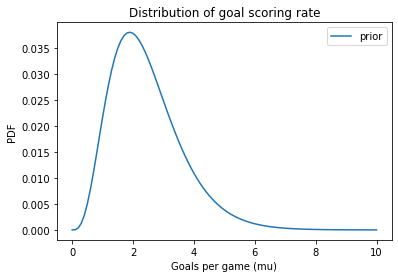

In [21]:
gamma_prior.plot(label='prior')
decorate_rate()

Now we can update it with the data.

In [22]:
data = 4
likelihood = poisson.pmf(data, mus)

In [23]:
posterior = gamma_prior * likelihood
posterior /= posterior.sum()

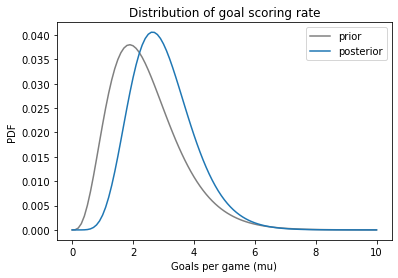

In [24]:
gamma_prior.plot(color='gray', label='prior')
posterior.plot(label='posterior')
decorate_rate()

In [25]:
gamma_prior.idxmax(), posterior.idxmax()

(1.9000000000000001, 2.6)

In [26]:
sample_prior_gamma = gamma(a=alpha, scale=1/beta).rvs(1000)
sample_prior_gamma.mean()

2.5073413898659362

## Back to PyMC

Previously we used PyMC to draw a sample from a Poisson distribution with known `mu`.

Now we'll use it to draw a sample from a gamma distribution of `mu`, with known `alpha` and `beta`.

And then use that value of `mu` to draw a sample from a Poisson distribution.

Here's what the PyMC model looks like:

In [27]:
model = pm.Model()

with model:
    mu = pm.Gamma('mu', alpha, beta)
    goals = pm.Poisson('goals', mu)
    trace = pm.sample_prior_predictive(1000)

The distribution of `mu` from this model is the prior.  Let's see what it looks like:

In [28]:
sample_prior_pymc = trace['mu']
np.mean(sample_prior_pymc)

2.432184554154777

And compare it to the gamma prior.

In [29]:
def plot_cdf(sample, **options):
    """Compute and plot the CDF of a sample."""
    pmf = make_pmf(sample)
    cdf = pmf.cumsum()
    plt.plot(cdf.index, cdf.values, **options)

In [30]:
def decorate_rate(ylabel='PDF'):
    """Decorate the axes."""
    plt.xlabel('Goals per game (mu)')
    plt.ylabel(ylabel)
    plt.title('Distribution of goal scoring rate')
    
    handles, labels = plt.gca().get_legend_handles_labels()
    if len(labels):
        plt.legend()

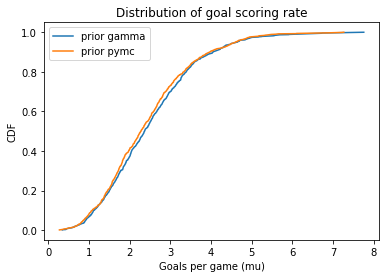

In [31]:
plot_cdf(sample_prior_gamma, label='prior gamma')
plot_cdf(sample_prior_pymc, label='prior pymc')
decorate_rate('CDF')

Looks good.

## When do we get to inference?

Finally, we are ready to use PyMC for actual inference.  We just have to make one small change.

Instead of generating `goals`, we'll mark goals as `observed` and provide the observed data, `4`.

And instead of calling `sample_prior_predictive`, we'll call `sample`, which is understood to sample from the posterior distribution of `mu`.

In [32]:
model = pm.Model()

with model:
    mu = pm.Gamma('mu', alpha, beta)
    goals = pm.Poisson('goals', mu, observed=4)
    trace = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1 seconds.
The acceptance probability does not match the target. It is 0.8841656349384467, but should be close to 0.8. Try to increase the number of tuning steps.


With `goals` fixed, the only unknown is `mu`, so `trace` contains a sample drawn from the posterior distribution of `mu`.  We can plot the posterior using a function provided by PyMC:

In [33]:
len(trace['mu'])

2000

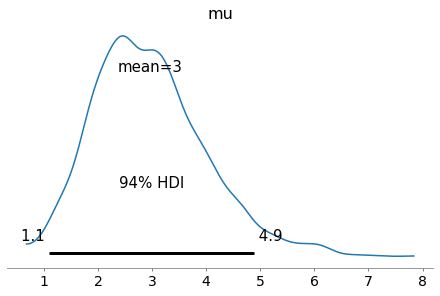

In [34]:
import arviz as az

with model:
    az.plot_posterior(trace)

We can extract a sample of `mu` from the trace.

In [35]:
sample_post_pymc = trace['mu']
np.mean(sample_post_pymc)

2.9678676599103415

And compare it to a sample from the grid approximation:

In [39]:
def sample_pmf(pmf, size):
    """Draw a sample from a PMF.
    
    pmf: Pandas Series
    size: number of elements
    
    returns: NumPy array
    """
    return np.random.choice(pmf.index, size, p=pmf.values)

In [40]:
sample_post_grid = sample_pmf(posterior, 1000)
sample_post_grid.mean()

2.9884000000000004

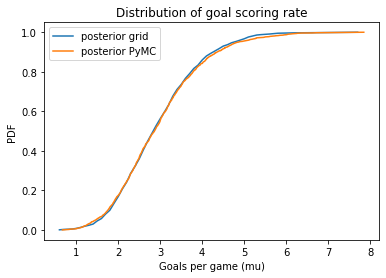

In [41]:
plot_cdf(sample_post_grid, label='posterior grid')
plot_cdf(sample_post_pymc, label='posterior PyMC')
decorate_rate()

Again, it looks pretty good.

## Two teams

We can extend the model to estimate different values of `mu` for the two teams.

In [42]:
model = pm.Model()

with model:
    mu_TBL = pm.Gamma('mu_TBL', alpha, beta)
    mu_MTL = pm.Gamma('mu_MTL', alpha, beta)
    goals_TBL = pm.Poisson('goals_TBL', mu_TBL, observed=[5,3])
    goals_MTL = pm.Poisson('goals_MTL', mu_MTL, observed=[1,1])
    trace = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_MTL, mu_TBL]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1 seconds.


We can use `traceplot` to review the results and do some visual diagnostics.

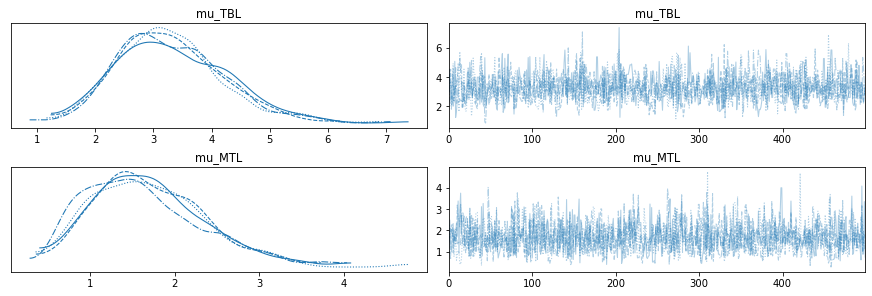

In [44]:
with model:
    az.plot_trace(trace);

Here are the posterior distribitions for `mu_MTL` and `mu_TBL`.

(1.687073228622372, 3.289651068846576)

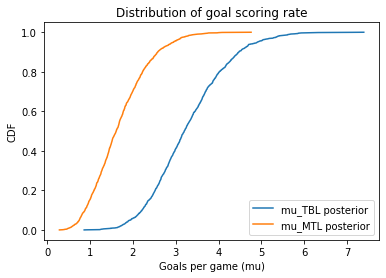

In [45]:
mu_TBL = trace['mu_TBL']
plot_cdf(mu_TBL, label='mu_TBL posterior')

mu_MTL = trace['mu_MTL']
plot_cdf(mu_MTL, label='mu_MTL posterior')

decorate_rate('CDF')
np.mean(mu_MTL), np.mean(mu_TBL)

On the basis of these two games, here's the probability that Tampa Bay is the better team.

In [47]:
np.mean(mu_TBL > mu_MTL)

0.923